# Delayed Self-Heterodyne Phase Noise Measurements With Coherent Phase Modulation Detection

This notebook focuses on metodologies presented in the work: 

[Delayed Self-Heterodyne Phase Noise Measurements With Coherent Phase Modulation Detection (2012)](https://ieeexplore.ieee.org/document/6064871)


I am starting with this work, because it study a system with only one laser

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import os
from optic.models.devices import photodiode, basicLaserModel
from optic.dsp.core import phaseNoise, firFilter, pulseShape
from optic.models.amplification import OSA, get_spectrum
from optic.utils import parameters
from optic.plot import plotPSD
from optic.comm.metrics import signal_power
from scipy.constants import c
from scipy.signal import hilbert
from scipy.signal.windows import hamming
from IPython.display import display, Math
from commpy.utilities  import upsample


fontSmall = {'family':'serif', 'weight':'normal', 'size':12}
font = {'family':'serif', 'weight':'normal', 'size':16}
fontTitle = {'family':'serif', 'weight':'normal', 'size':20}

# DFB Semiconductor Laser Simulation using Python

This Python script simulates the behavior of a distributed feedback (DFB) semiconductor laser.
It models the laser dynamics, output power over time, and optical spectrum.
The simulation is based on a set of differential equations and numerical methods.

Author: Mohammed Mehdi Bouchene 
(https://github.com/Bouchenemehdi24/DFB-Semiconductor-Laser-Simulation-using-Python-and-Numba)

References:
1. Bouchene, M. M., & Hamdi, R. (2018). The effect of facets reflectivity on the static characteristics of (DFB) semiconductor laser.
   In 2018 International Conference on Electrical Sciences and Technologies in Maghreb (CISTEM) (pp. 1-4). IEEE.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftshift
from numba import jit



# Define laser Material and structure parameters
c = 3e10  # velocity of light in free space
q = 1.602e-19  # electron charge
h0 = 6.626e-34  # planck
wl = 1.55e-4  # reference lasing wavelength (cm?)
f0 = c / wl
gratingperiod = 242.1875e-7  # Grating period (cm) 2*3.2*242.1875e-3um=1.55um
L = 600e-4  # Laser length (cm)
d = 0.2e-4  # Thickness (cm)
w = 1.5e-4  # Width (cm)
V = L * d * w  # active region Volume (cm^3)
gama = 0.3  # Confinement factor
neff = 3.2  # Effective index without injection
ng = 3.6  # Group index
vg = c / ng  # group velocity
a = 10  # Internal loss (cm^-1)
gN = 2.5e-16  # Differential gain (cm^2)
NO = 1e18  # Transparent carrier density (cm^-3)
e = 5e-17  # Non-linear gain saturation coefficient (cm^3)
am = 4  # Linewidth enhancement factor
A = 0.1e9  # Linear recombination coefficient (s^-1)
B = 1e-10  # Bimolecular radiation coefficient (cm^3*s^-1)
C = 7.5e-29  # Auger coefficient (cm^-6*s^-1)
b = 5e-5  # Spontaneous emission coefficient
K = 1  # Transverse Peterman factor


# Left and right facets parameters
# HR facet
# left facet power reflectivity

rl = 0.98
rr = 0.1

# Computing parameters
M = 60  # SPACE mesh number
T = 5e-9  # 5ns
deltz = L / M  # space step
deltt = deltz / vg
tnum = round(T / deltt)  # total time step

sinto = np.ones(M)
costo = np.ones(M)


# Drive current
D = 50
I = D * 0.001


kapa = 150 * L
# set initial field and power and carrier density

F = np.zeros(M + 1, dtype=complex)
R = np.zeros(M + 1, dtype=complex)


Ft = np.zeros(tnum, dtype=complex)
Rt = np.zeros(tnum, dtype=complex)
S = np.zeros(M)
S1 = np.zeros((3, M))
N = np.ones(M) * NO
PO = np.zeros(tnum)
POO = np.zeros(tnum)
lamda_t = np.zeros(tnum)
sn1 = 1

![Heterodyne Setup](../../IlustrationMedia/LaserCavity_MSections.png)

The optical fields (propagation and backpropagation) are defined as: $$ \begin{cases} \frac{1}{v_g}\frac{\partial E^+}{\partial t}+\frac{\partial E^+}{\partial z} = \text{gain and loss terms} + \zeta^+(z,t) \\ \frac{1}{v_g}\frac{\partial E^-}{\partial t}-\frac{\partial E^-}{\partial z} = \text{gain and loss terms} + \zeta^-(z,t) \end{cases} $$

where $v_g$ is the **group velocity** in the active medium and $\zeta^+$ and $\zeta^-$ are the **Spontaneous Emission Noise** terms associated with forward and backward traveling waves. The correlation function is defined as follows: $$\langle \zeta(z,t),\zeta^*(z',t') \rangle = K \Gamma_{sp} b R_{sp} L \delta(t-t') \delta(z-z') / v_g^2$$
Where $\Gamma_{sp}$ is the **Spontaneous emission confinement factor**, $K$ is the **Peterman factor**, $L$ is the **cavity length**, $b$ is the **Spontaneous emission coefficient**, and $R_{sp}$ is the **spontaneous emission rate**. The delta diracs guarantee that the white noise is present in both space and time



Spontaneus Emission Noise: $$\zeta = \sqrt{\frac{b \cdot \Gamma_{sp} \cdot K \cdot B \cdot N^2}{\Delta z \cdot v_g}}$$ 
where $B$ is the **bimolecular radiation coefficient**, $N$ is the **carrier density**, and $\Delta z$ is the **simulation longitudinal step**.

c:\Users\PC\Documents\PythonVenvs\TCCvenv\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\PC\Documents\PythonVenvs\TCCvenv\lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<Figure size 640x480 with 0 Axes>

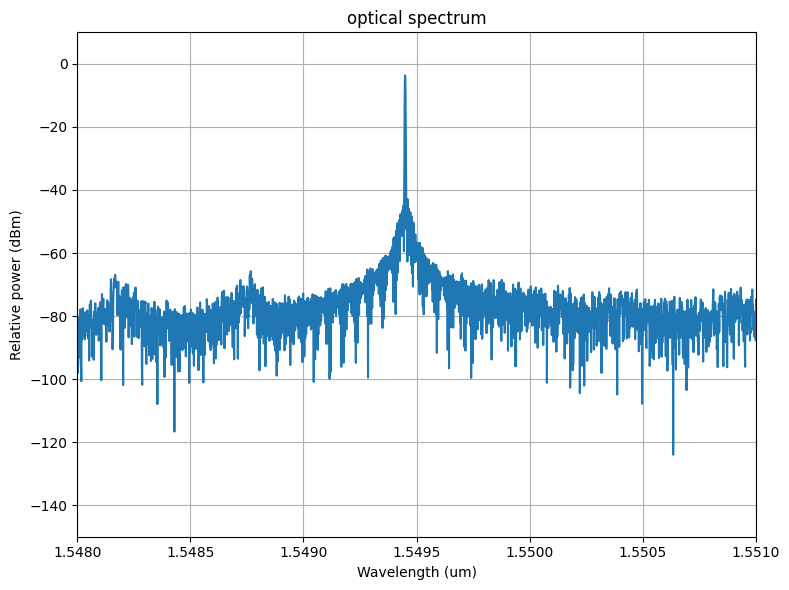

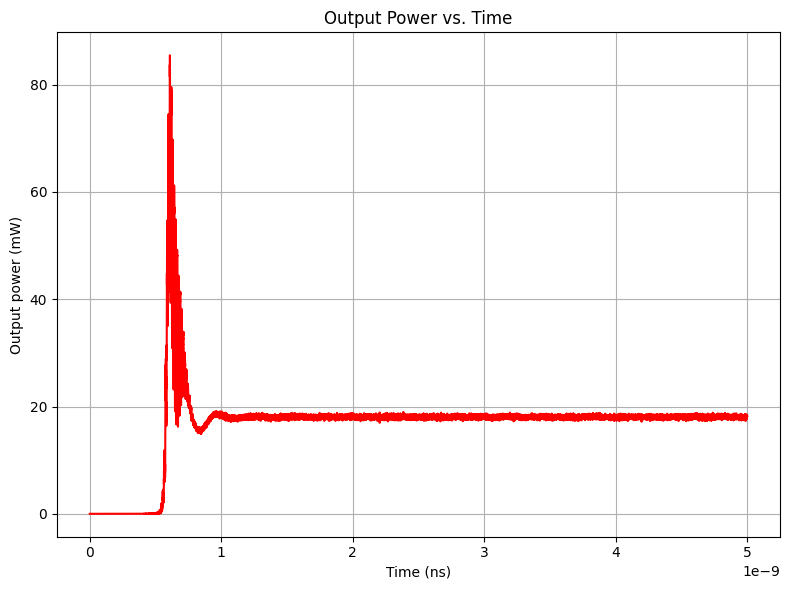

In [13]:
@jit(nopython=True)

def main_program(tnum, S1, F, R, Ft, Rt, S, N, PO, POO, lamda_t):

    # MAIN program
    for tn in range(tnum):  # building up fields over tnum time steps
        S1[0, :] = S

        # Net optical gain (ref. equation 4)
        G = 0.5 * (gama * gN * (N - NO) / (1 + e * S) - a) 
        
        # Detuning factor (ref. equation 6 applied on ref. equation 7)
        Detu = 2 * np.pi * (neff - am * gama * gN * (N - NO) * wl / (4 * np.pi * (1 + e * S))) / wl - np.pi / gratingperiod

        Spn = np.sqrt(np.abs(b * gama * K * B * N ** 2 / (deltz * vg)))
        a1 = np.random.randn(M)
        b1 = 2 * np.pi * np.random.rand(M)
        Spn1 = sn1 * Spn * a1 * np.exp(1j * b1)  # set up for random forward and backward spontaneous input

        # MAIN GUTS FOR UPDATING FIELDS and adding in spontaneous emission
        temp_f = np.exp((G - 1j * Detu) * deltz) * F[:-1] + deltz * Spn1
        temp_r = np.exp((G - 1j * Detu) * deltz) * R[1:] + deltz * Spn1
        F[0] = rl * R[0]
        R[-1] = rr * F[-1]

        F[1:] = np.cosh(kapa * deltz) * temp_f * costo - 1j * np.sinh(kapa * deltz) * temp_r * costo
        R[:-1] = -1j * np.sinh(kapa * deltz) * temp_f * sinto + np.cosh(kapa * deltz) * temp_r * sinto

        # photon density
        S = 0.5 * (np.abs(F[:-1]) ** 2 + np.abs(R[:-1]) ** 2) + 0.5 * (np.abs(F[1:]) ** 2 + np.abs(R[1:]) ** 2)

        S1[1, :] = S
        S1[2, :] = 0.5 * (S1[0, :] + S1[1, :])

        # carrier distribution
        N = N + (I / (q * V) - A * N - B * N ** 2 - C * N ** 3 - vg * gN * (N - NO) * S / (1 + e * S)) * deltt

        # OUTPUT RELATIONSHIPS
        PO[tn] = np.abs(F[-1]) ** 2 * V * vg * h0 * c * (1 - rr ** 2) / (wl * L * gama)  # right hand side's output power
        Ft[tn] = F[-1]

        POO[tn] = np.abs(R[-1]) ** 2 * V * vg * h0 * c * (1 - rl ** 2) / (wl * L * gama)  # Left hand side's output power
        Rt[tn] = R[-1]

        lamda_t[tn] = 2 * gratingperiod * (-wl * am * gama * gN * ((N[-1] - NO)) / 4 / np.pi)

main_program(tnum, S1, F, R, Ft, Rt, S, N, PO, POO, lamda_t)


Ftt = Ft[tnum - round(4e-9 / deltt):tnum]
NFFT = 2**np.ceil(np.log2(len(Ftt)))
fs = 1 / deltt
Yy = fftshift(fft(Ftt * np.hamming(len(Ftt)), int(NFFT)))

magy = Yy * np.conj(Yy) / NFFT
my = len(Yy)
fy = np.arange(-my / 2, my / 2) * fs / my
wave2 = (c / (fy + f0)) * 10**4  # um


plt.figure()
waveshape = magy[0:my] / np.max(magy)
plt.figure(figsize=(8, 6))
plt.plot(wave2, 10 * np.log10(magy[0:my] / np.max(magy)))
plt.xlabel('Wavelength (um)')
plt.ylabel('Relative power (dBm)')

plt.title('optical spectrum')

plt.grid(True)

plt.axis([1.530, 1.570, -150, 10])
# plt.xlim([1.530, 1.570])
plt.xlim([1.548, 1.551])
plt.tight_layout()

for xx in range(tnum - 1):
    PO[xx] = 0.5 * (PO[xx] + PO[xx + 1])

ORight = PO[1:tnum - 1] * 1000
ttt = np.arange(1, tnum - 1) * deltt

plt.figure(figsize=(8, 6))
plt.plot(ttt, ORight, 'r')  # mW
plt.xlabel('Time (ns)')
plt.ylabel('Output power (mW)')
plt.title('Output Power vs. Time')
plt.grid(True)
plt.tight_layout()

# Another DFB model

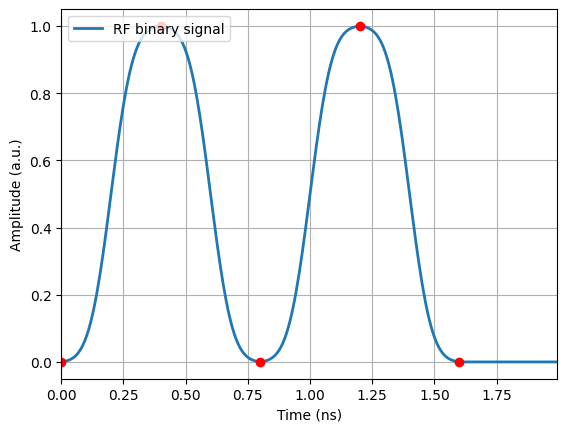

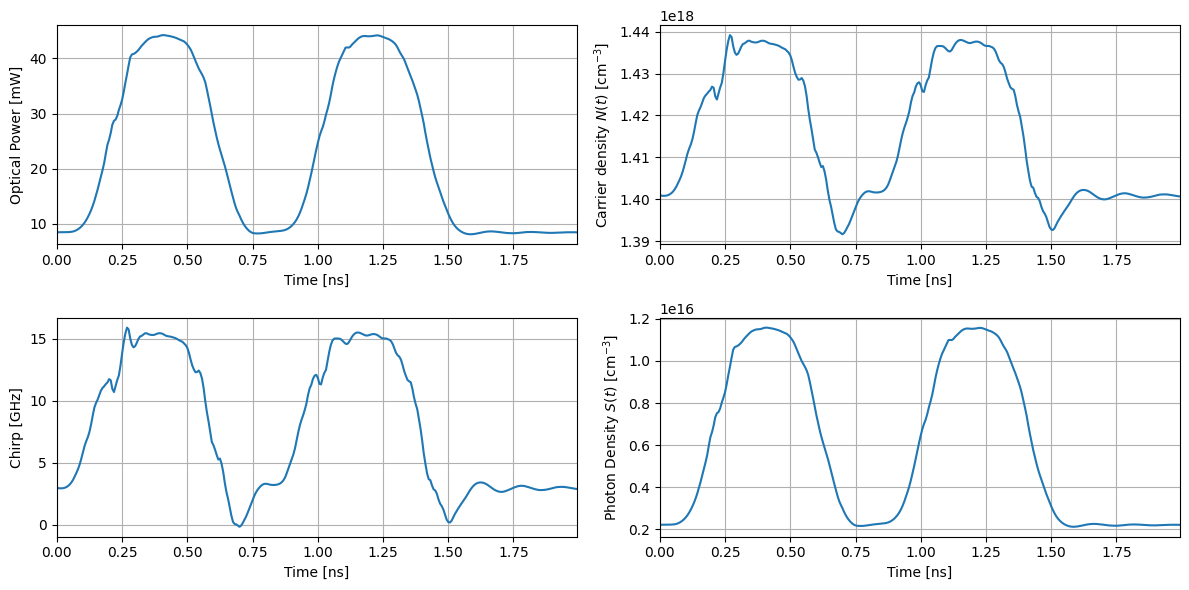

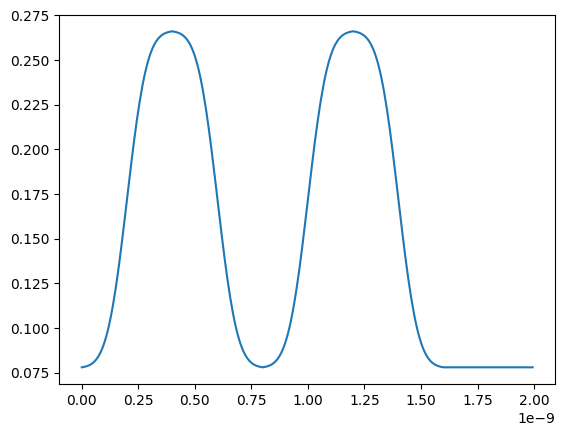

In [ ]:
# References:
# [1] - J. C. Cartledge and R. C. Srinivasan, "Extraction of DFB laser rate equation parameters for system simulation purposes," in Journal of Lightwave Technology, vol. 15, no. 5, pp. 852-860, 1997.
# [2] - I. Fatadin, D. Ives and M. Wicks, "Numerical simulation of intensity and phase noise from extracted parameters for CW DFB lasers," in IEEE Journal of Quantum Electronics, vol. 42, no. 9, pp. 934-941, 2006.
#
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.integrate import solve_ivp,odeint
from scipy.constants import c, h, e

# Routines for DFB laser simulation.
class laser_dfb():
    def __init__(self, parameters):
        ## add noise terms
        self.noise_terms = getattr(parameters, "noise_terms", False)
        # active layer volume
        self.v = getattr(parameters, "v", 1.5e-10)
        # electron lifetime
        self.tau_n = getattr(parameters, "tau_n", 1.0e-9)
        # active layer gain coefficient
        self.a0 = getattr(parameters, "a0", 2.5e-16)
        # group velocity
        self.vg = getattr(parameters, "vg", 8.5e+9)
        # carrier density at transparency
        self.n_t = getattr(parameters, "n_t", 1.0e+18)
        # gain compression factor
        self.epsilon = getattr(parameters, "epsilon", 1.0e-17)
        # mode confinement factor
        self.gamma = getattr(parameters, "gamma", 0.4)
        # photon lifetime
        self.tau_p = getattr(parameters, "tau_p", 3.0e-12)
        # fraction of spontaneous emission coupling
        self.beta = getattr(parameters, "beta", 3.0e-5)
        # linewidth enchancement factor
        self.alpha = getattr(parameters, "alpha", 5)
        # gain cross section
        self.sigma = getattr(parameters, "sigma", 2e-20)
        # i_bias
        self.i_bias = getattr(parameters, 'i_bias', 0.078)
        # i_max
        self.i_max  = getattr(parameters, 'i_max', 0.188)
        # total differential quantum efficiency
        self.eta_0 = getattr(parameters, 'eta_0', 0.4)
        # wavelength
        self.lmbd = getattr(parameters, 'lmbd', 1300e-9)
        # frequency
        self.freq_0  = c/self.lmbd
        # threshold current
        self.ith = e/self.tau_n*self.v*(self.n_t + 1/(self.gamma * self.tau_p * self.vg * self.a0))
        
    def get_current(self, t):
        return np.real(self.current[np.argwhere(t >= self.t)[-1]])
    
    def set_current(self, t, current):
        # set variables
        self.current = self.i_max * current + self.i_bias
        self.t = t
        self.t_step = t[1]-t[0]
        
    def set_laser_dynamic_response(self, y):
        # get variables
        self.N = y[0,:]
        self.S = y[1,: ]
        self.phase = y[2,:]
        # calculate others parameters
        self.power = (self.S/2) * (self.v * h * self.freq_0 * self.eta_0)/(self.gamma * self.tau_p)
        self.chirp = 1/(2*np.pi) * (self.alpha / 2) * (self.gamma * self.vg * self.a0 * (self.N - self.n_t) - 1/self.tau_p) # np.diff(y[2,:],prepend=y[2,0])/self.t_step
        self.e_out = np.sqrt(np.real(self.power)) * np.exp(1j * self.phase)

    def get_initial_conditions(self):
        y0 = np.zeros([3])        
        y0[1] = self.gamma * self.tau_p/(self.v * e) * (self.get_current(0)-self.ith)
        y0[0] = self.n_t + (1 + self.epsilon * y0[1]) / (self.vg * self.a0 * self.gamma * self.tau_p)
        y0[2] = (self.alpha / 2) * (self.gamma * self.vg * self.a0 * (y0[0] - self.n_t) - 1 / self.tau_p)
        return y0

    def solve(self, t, current):
        self.set_current(t, current)
        # Initial conditions        
        sol = solve_ivp(
            self.laser_rate_equations,
            t_span=[t[0], t[-1]],
            y0=self.get_initial_conditions(),
            method='RK45',
            t_eval = t,
            dense_output=True,
            #rtol = 1e-4,
            #atol = 1e-6,
        )
        self.set_laser_dynamic_response(sol['y'])
        return sol

    def laser_rate_equations(self, t, y):
        dy = np.zeros([3])        
        # Carrier density
        dy[0] = self.carrier_density(t,y)
        # Foton density
        dy[1] = self.photon_density(y)
        # Optical phase
        dy[2] = self.optical_phase(y)
        return self.add_noise_rate_equations(y,dy)

    def add_noise_rate_equations(self,y,dy):
        # noise terms
        dn = np.zeros(3)
        if self.noise_terms:
            dn = self.laser_noise_sources(y)
        return (dy + dn)

    def laser_noise_sources(self, y):
        # noise term 
        # diffusion coefficient - see ref. [2]
        dss = (self.beta*y[0]*y[1]/self.tau_n)
        #dnn = (y[0]/self.tau_n)*(1+self.beta*y[1])
        dpp = (self.beta*y[0])/(4*self.tau_n*y[1])
        dzz = y[0]/self.tau_n
        # noise sources
        fs = np.random.randn()*np.sqrt(2*dss/self.t_step)
        fz = np.random.randn()*np.sqrt(2*dzz/self.t_step)
        fp = np.random.randn()*np.sqrt(2*dpp/self.t_step)
        fn = fz - fs
        return [fn, fs, fp]

    def carrier_density(self, t, y):        
        return self.get_current(t)/(e*self.v)-y[0]/self.tau_n-self.vg*self.a0*y[1]*(y[0]-self.n_t)/(1+self.epsilon*y[1])
    
    def photon_density(self, y):
        return (self.gamma * self.a0 * self.vg * ((y[0]-self.n_t)/(1+self.epsilon*y[1]))-1/self.tau_p)*y[1]+self.beta*self.gamma*y[0]/self.tau_n
    
    def optical_phase(self, y):
        return self.alpha/2 * (self.gamma*self.vg*self.a0*(y[0]-self.n_t)-1/self.tau_p)

    def get_im_response(self, f, type='exact'):
        Y, Z = self.im_response_yz()
        if type=='exact':
            return Y, Z, self.im_response_hf(f,Y,Z)
        elif type=='approx.':
            return Y, Z, self.im_response_haf(f,Y,Z)
        else:
            print('Invalid type of IM response.')
            return -1

    def im_response_hf(self,f,Y,Z):
        return Z/((1j*2*np.pi*f)**2+1j*2*np.pi*f*Y+Z)

    def im_response_haf(self,f,Y,Z):
        fr = 1/(2*np.pi)*np.sqrt(Z)
        return fr**2/((fr**2-f**2)+1j*f*Y/(2*np.pi))

    def im_response_yz(self):
        # Intensity modulation frequency response - see ref. [1]
        Y = self.vg*self.a0*self.S[-1]/(1+self.epsilon*self.S[-1]) + 1/self.tau_n + 1/self.tau_p
        Y = Y - self.gamma*self.a0*self.vg*(self.N[-1]-self.n_t)/(1+self.epsilon*self.S[-1])**2
        Z = self.vg*self.a0*self.S[-1]/(1+self.epsilon*self.S[-1]) * 1/self.tau_p + 1/(self.tau_p*self.tau_n)
        Z = Z + (self.beta-1)*self.gamma*self.a0*self.vg/self.tau_n*(self.N[-1]-self.n_t)/(1+self.epsilon*self.S[-1])**2
        return Y,Z
    
    def plot(self):
        fig,ax=plt.subplots(2,2,figsize=(12,6))
        ax[0,0].plot(1e9*self.t, 1e3*self.power)
        self._extracted_from_plot_4(ax, 0, 0, 'Optical Power [mW]')
        ax[1,0].plot(1e9*self.t, 1e-9*np.real(self.chirp))
        self._extracted_from_plot_4(ax, 1, 0, 'Chirp [GHz]')
        ax[0,1].plot(1e9*self.t, np.real(self.N))
        self._extracted_from_plot_4(ax, 0, 1, r'Carrier density $N(t)$ [cm$^{-3}$]')
        ax[1,1].plot(1e9*self.t, np.real(self.S))
        self._extracted_from_plot_4(ax, 1, 1, r'Photon Density $S(t)$ [cm$^{-3}$]')
        plt.tight_layout()
        return ax

    def _extracted_from_plot_4(self, ax, arg1, arg2, arg3):
        ax[arg1, arg2].set_xlabel('Time [ns]')
        ax[arg1, arg2].set_ylabel(arg3)
        ax[arg1, arg2].set_xlim(1e9*np.array([self.t.min(),self.t.max()]))
        ax[arg1, arg2].grid(True)
        
if __name__ == "__main__":

    import matplotlib.pyplot as plt
    import random

    from Functions.laser_dfb import laser_dfb

    # simulation parameters
    SpS = 64
    Rs = 2.5e9 # Symbol rate (for OOK case Rs = Rb)
    Tsymb = 1/Rs # Symbol period in seconds
    Fs = 1/(Tsymb/SpS) # Signal sampling frequency (samples/second)
    Ts = 1/Fs # Sampling period

    laser_dfb_parameters = parameters()
    laser = laser_dfb(laser_dfb_parameters)

    # generate pseudo-random bit sequence
    bitsTx = [0, 1, 0, 1, 0] #np.random.randint(2, size=10)
    #n = np.arange(0, bitsTx.size)

    # upsampling
    symbolsUp = upsample(bitsTx, SpS)

    # typical NRZ pulse
    pulse = pulseShape('nrz', SpS)
    pulse = pulse/max(abs(pulse))

    # pulse formatting
    sigTx = firFilter(pulse, symbolsUp)

    t = np.arange(0,SpS*len(bitsTx))*Ts
    plt.plot(1e9*t, sigTx, label = 'RF binary signal', linewidth=2)
    plt.plot(1e9*t[::SpS], bitsTx, 'ro')
    plt.ylabel('Amplitude (a.u.)')
    plt.xlabel('Time (ns)')
    plt.xlim([1e9*t.min(), 1e9*t.max()])
    plt.legend(loc='upper left')
    plt.grid()

    sol = laser.solve(t, sigTx)
    laser.plot()
    plt.figure()
    plt.plot(laser.t, laser.current)

# 50:50 Coupling, SMF, and PM modulation